# Topic Modeling (LDA) on Japanese Text

## 0. Install libraries

In [3]:
!pip install mojimoji
!pip install MeCab

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


## 1. Reading in Japanese news corpus

In [4]:
import pandas as pd
import re
from collections import Counter, OrderedDict, defaultdict
import MeCab
import mojimoji

In [5]:
# news corpus gained from: https://nxdataka.netlify.app/ldncsv/
df = pd.read_csv("./livedoornews.csv")

In [6]:
df.shape

(7367, 5)

In [7]:
df

,url,datetime,title,body,media
0,http://news.livedoor.com/article/detail/5978741/,2011-10-30T10:15:00+0900,【DVDエンター！】誘拐犯に育てられた女が目にした真実は、孤独か幸福か,2005年11月から翌2006年7月まで読売新聞にて連載された、直木賞作家・角田光代による初...,movie-enter
1,http://news.livedoor.com/article/detail/6322901/,2012-02-29T11:45:00+0900,藤原竜也、中学生とともにロケット打ち上げに成功,「アンテナを張りながら生活をしていけばいい」\n2月28日、映画『おかえり、はやぶさ』（3月...,movie-enter
2,http://news.livedoor.com/article/detail/6176324/,2012-01-09T14:00:00+0900,『戦火の馬』ロイヤル・プレミアにウィリアム王子＆キャサリン妃が出席,3月2日より全国ロードショーとなる、スティーブン・スピルバーグの待望の監督最新作『戦火の馬』...,movie-enter
3,http://news.livedoor.com/article/detail/6573929/,2012-05-19T12:00:00+0900,香里奈、女子高生100人のガチンコ質問に回答「ラーメンも食べる」,女優の香里奈が18日、都内で行われた映画『ガール』（5月26日公開）の女子高生限定試写会にサ...,movie-enter
4,http://news.livedoor.com/article/detail/5914880/,2011-10-05T19:11:00+0900,ユージの前に立ちはだかったJOY「僕はAKBの高橋みなみを守る」,5日、東京・千代田区の内幸町ホールにて、映画『キャプテン・アメリカ/ザ・ファースト・アベンジ...,movie-enter
...,...,...,...,...,...
7362,http://news.livedoor.com/article/detail/6530260/,2012-05-05T09:55:00+0900,好きな戦士を作ってドラゴンボールの世界で天下一武道会優勝だ！「挑戦！天下一武道会」【Andr...,どんな戦士を作るかはユーザー次第！\n国民的人気を誇る鳥山明氏のマンガ／アニメである「DRA...,smax
7363,http://news.livedoor.com/article/detail/6681611/,2012-06-21T20:55:00+0900,NTTドコモ、GALAXY SIII SC-06DとF-09D ANTEPRIMAの発売日を...,GALAXY SIIIが6月28日、F-09D ANTEPRIMAが6月27日に発売！\nN...,smax
7364,http://news.livedoor.com/article/detail/6856578/,2012-08-15T11:55:00+0900,NTTドコモ、Android向け「docomo Wi-Fiかんたん接続アプリ」をバージョンア...,shimajiro@mobiler\nNTTドコモは、同社の公衆無線LANサービス「doco...,smax
7365,http://news.livedoor.com/article/detail/6678539/,2012-06-21T06:55:00+0900,NTTドコモ、PRADA Phone by LG L-02Dのデコメ絵文字popが正常に表示...,PRADA Phone by LG L-02Dにソフトウェア更新！\nNTTドコモは20日、...,smax


## 2. Preprocess text (Tokenization + POS tagging)

In [8]:
# class to handle preprocessing
class MeCabHandler:
    def __init__(self, tagger):
        self._handler = tagger

    def surface(self, text):
        self._handler.parse("")
        result = self._handler.parseToNode(text)
        filtered_words = []
        while result:
            filtered_words.append(result.surface)
            result = result.next

        return filtered_words

    def pos(self, text):
        self._handler.parse("")
        result = self._handler.parseToNode(text)
        pos = []
        while result:
            features = result.feature.split(',')
            pos.append(features[0])
            result = result.next

        return pos

# preprocessing text
def preprocess(text):
    text = text.lower()
    text = mojimoji.zen_to_han(text, kana=False)
    text = mojimoji.han_to_zen(text, digit=False, ascii=False)
    text = text.translate(str.maketrans({
        '!': '！', '"': '”', '#': '＃', '$': '＄', '%': '％', '&': '＆', '\'': '’',
        '(': '（', ')': '）', '*': '＊', '+': '＋', ',': '，', '-': '−', '.': '．',
        '/': '／', ':': '：', ';': '；', '<': '＜', '=': '＝', '>': '＞', '?': '？',
        '@': '＠', '[': '［', '\\': '＼', ']': '］', '^': '＾', '_': '＿', '`': '｀',
        '{': '｛', '|': '｜', '}': '｝'
        }))
    zenkaku_leftsingle = b'\xe2\x80\x98'.decode('utf-8')
    text = re.sub('[’´｀]', zenkaku_leftsingle, text)
    return text


# function to check encoding errors
def getEncode(filepath):
    encs = "iso-2022-jp euc-jp shift_jis utf-8".split()
    for enc in encs:
        with open(filepath, encoding=enc) as fr:
            try:
                fr = fr.read()
            except UnicodeDecodeError:
                continue
        return enc


In [9]:
def preprocessDf(filename):
    """Reads in Japanese news dataframe from filename, and returns a corpus of the body text tokenized,
    as well as part-of-speech (pos) tags for them."""
    # read in and define dependencies
    mt = MeCab.Tagger("-Ochasen -u " + "user_dict.dic")
    handler = MeCabHandler(mt)
    enc = getEncode(FILENAME)
    df = pd.read_csv(FILENAME, encoding=enc)
    preprocessedRow = OrderedDict()
    outDf = pd.DataFrame()
    
    for i, row in df.iterrows():
        
        url = row["url"]
        datetime = row["datetime"]
        title = row["title"]
        body = row["body"]
        media = row["media"]
        
        # preprocess text
        filteredText = preprocess(body)
        tokenizedText = " ".join(handler.surface(filteredText)[1:-1])
        
        preprocessedRow["url"] = url
        preprocessedRow["datetime"] = datetime
        preprocessedRow["body"] = tokenizedText
        
        # calculate pos rate
        computePosRate(handler, tokenizedText, preprocessedRow)
        
        # Append to Dataframe
        outDf = outDf.append(pd.DataFrame(preprocessedRow, index=[i]))
        
    return outDf

def computePosRate(handler, text, preprocessedRow):
    """Using the tokenized text, appends part-of-speech tagging features."""
    # Calculate pos_rate
    pos = handler.pos(text)[1:-1]

    cnt = Counter(pos).most_common()
    wc = len(pos)
    preprocessedRow["WC"] = wc
    for tpl in cnt:
        preprocessedRow[tpl[0]] = '{:.2f}'.format((tpl[1] / wc)*100)
        
    return

In [10]:
# define filename for input corpus
FILENAME = './livedoornews.csv'

In [11]:
preprocessedDf = preprocessDf(FILENAME)
preprocessedDf.to_csv("./preprocessed_corpus.csv")

In [12]:
preprocessedDf

,url,datetime,body,WC,名詞,助詞,記号,動詞,助動詞,副詞,連体詞,接頭詞,接続詞,形容詞,感動詞,フィラー,その他
0,http://news.livedoor.com/article/detail/5978741/,2011-10-30T10:15:00+0900,2005 年 11 月 から 翌 2006 年 7 月 まで 読売新聞 にて 連載 さ れ ...,800,42.12,23.62,12.00,11.88,8.12,0.88,0.50,0.38,0.25,0.25,NaN,NaN,NaN
1,http://news.livedoor.com/article/detail/6322901/,2012-02-29T11:45:00+0900,「 アンテナ を 張り ながら 生活 を し て いけ ば いい 」 2 月 28 日 、 ...,1264,34.18,26.66,12.66,13.13,8.86,1.98,0.55,0.47,0.08,0.87,0.40,0.16,NaN
2,http://news.livedoor.com/article/detail/6176324/,2012-01-09T14:00:00+0900,3 月 2 日 より 全国 ロードショー と なる 、 スティーブン ・ スピルバーグ の ...,1267,38.20,26.52,12.47,11.92,5.29,1.03,1.34,0.95,0.47,1.82,0.40,0.16,NaN
3,http://news.livedoor.com/article/detail/6573929/,2012-05-19T12:00:00+0900,女優 の 香里奈 が 18 日 、 都内 で 行わ れ た 映画 『 ガール 』 （ 5 月...,600,29.67,26.00,19.17,12.50,7.50,1.67,0.50,0.67,0.67,1.33,0.33,0.16,NaN
4,http://news.livedoor.com/article/detail/5914880/,2011-10-05T19:11:00+0900,5 日 、 東京 ・ 千代田 区 の 内幸町 ホール にて 、 映画 『 キャプテン ・ ア...,1149,33.77,25.76,15.67,10.53,10.18,1.48,0.70,0.26,0.78,0.87,0.33,0.16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7362,http://news.livedoor.com/article/detail/6530260/,2012-05-05T09:55:00+0900,どんな 戦士 を 作る か は ユーザー 次第 ！ 国民 的 人気 を 誇る 鳥山 明 氏 ...,793,37.58,24.34,14.25,11.98,7.82,0.63,0.38,0.13,0.76,2.02,0.15,0.13,0.21
7363,http://news.livedoor.com/article/detail/6681611/,2012-06-21T20:55:00+0900,galaxy siii が 6 月 28 日 、 f − 09 d anteprima が ...,293,61.09,10.24,22.53,3.07,2.39,0.63,0.38,0.34,0.76,0.34,0.15,0.13,0.21
7364,http://news.livedoor.com/article/detail/6856578/,2012-08-15T11:55:00+0900,shimajiro ＠ mobiler ntt ドコモ は 、 同社 の 公衆 無線 lan...,1066,49.34,21.48,16.89,7.04,2.63,0.66,0.38,0.56,0.09,0.94,0.15,0.13,0.21
7365,http://news.livedoor.com/article/detail/6678539/,2012-06-21T06:55:00+0900,prada phone by lg l − 02 d に ソフトウェア 更新 ！ ntt ド...,982,45.01,18.43,17.01,11.10,5.91,0.51,0.20,0.51,0.51,0.81,0.15,0.13,0.21


## 3. Perform LDA on corpus

In [13]:
# Read preprocessed corpus
df = pd.read_csv("./preprocessed_corpus.csv")

In [14]:
def analyzer(text, mecab, stopwords=[], target_part_of_speech=['proper_noun', 'noun', 'verb', 'adjective']):

    node = mecab.parseToNode(text)
    words = []

    while node:
        features = node.feature.split(',')
        surface = features[6]

        if (surface == '*') or (len(surface) < 2) or (surface in stopwords):
            node = node.next
            continue

        noun_flag = (features[0] == '名詞')
        proper_noun_flag = (features[0] == '名詞') & (features[1] == '固有名詞')
        verb_flag = (features[0] == '動詞') & (features[1] == '自立')
        adjective_flag = (features[0] == '形容詞') & (features[1] == '自立')

        if ('proper_noun' in target_part_of_speech) & proper_noun_flag:
            words.append(surface)
        elif ('noun' in target_part_of_speech) & noun_flag:
            words.append(surface)
        elif ('verb' in target_part_of_speech) & verb_flag:
            words.append(surface)
        elif ('adjective' in target_part_of_speech) & adjective_flag:
            words.append(surface)

        node = node.next

    return words

## Adding Stopwords

In [15]:
import urllib

req = urllib.request.Request('http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt')

with urllib.request.urlopen(req) as res:
    stopwords = res.read().decode('utf-8').split('\r\n')

while '' in stopwords:
    stopwords.remove('')

print(stopwords)

['あそこ', 'あたり', 'あちら', 'あっち', 'あと', 'あな', 'あなた', 'あれ', 'いくつ', 'いつ', 'いま', 'いや', 'いろいろ', 'うち', 'おおまか', 'おまえ', 'おれ', 'がい', 'かく', 'かたち', 'かやの', 'から', 'がら', 'きた', 'くせ', 'ここ', 'こっち', 'こと', 'ごと', 'こちら', 'ごっちゃ', 'これ', 'これら', 'ごろ', 'さまざま', 'さらい', 'さん', 'しかた', 'しよう', 'すか', 'ずつ', 'すね', 'すべて', 'ぜんぶ', 'そう', 'そこ', 'そちら', 'そっち', 'そで', 'それ', 'それぞれ', 'それなり', 'たくさん', 'たち', 'たび', 'ため', 'だめ', 'ちゃ', 'ちゃん', 'てん', 'とおり', 'とき', 'どこ', 'どこか', 'ところ', 'どちら', 'どっか', 'どっち', 'どれ', 'なか', 'なかば', 'なに', 'など', 'なん', 'はじめ', 'はず', 'はるか', 'ひと', 'ひとつ', 'ふく', 'ぶり', 'べつ', 'へん', 'ぺん', 'ほう', 'ほか', 'まさ', 'まし', 'まとも', 'まま', 'みたい', 'みつ', 'みなさん', 'みんな', 'もと', 'もの', 'もん', 'やつ', 'よう', 'よそ', 'わけ', 'わたし', 'ハイ', '上', '中', '下', '字', '年', '月', '日', '時', '分', '秒', '週', '火', '水', '木', '金', '土', '国', '都', '道', '府', '県', '市', '区', '町', '村', '各', '第', '方', '何', '的', '度', '文', '者', '性', '体', '人', '他', '今', '部', '課', '係', '外', '類', '達', '気', '室', '口', '誰', '用', '界', '会', '首', '男', '女', '別', '話', '私', '屋', '店', '家', '場', '等', '見', '際', '観', '段', '

In [16]:
sample_text = df["body"][0]

mecab = MeCab.Tagger("-Ochasen -u" + "user_dict.dic")
words = analyzer(sample_text, mecab, stopwords=stopwords, target_part_of_speech=["noun", "proper_noun"])

In [17]:
# Uncomment the following to see nouns and proper nouns of the first news article in dataset

# words

### Use gensim and the analyzer previously created in order to create a dictionary of word ids and a bag-of-words corpus

In [18]:
import gensim

mecab = MeCab.Tagger("-Ochasen -u" + "user_dict.dic")

import time

t0 = time.time()

texts = []
for text in df["body"]:
    words = analyzer(text, mecab, stopwords=stopwords, target_part_of_speech=["noun", "proper_noun"])
    texts.append(words)

dictionary = gensim.corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=3, no_above=0.8)
corpus = [dictionary.doc2bow(t) for t in texts]

# LDA
num_topics = 20
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=0)

print("finished in " + str(time.time() - t0) + "s")

finished in 20.76107907295227s


In [19]:
print("vocab size: ", len(dictionary))

vocab size:  17528


In [20]:
# peeking at topics
lda_model.print_topics()

[(0,
  '0.032*"更新" + 0.016*"タップ" + 0.016*"紹介" + 0.014*"表示" + 0.012*"画面" + 0.011*"機能" + 0.009*"記事" + 0.008*"情報" + 0.008*"カテゴリ" + 0.007*"登録"'),
 (1,
  '0.012*"女性" + 0.010*"男性" + 0.009*"交際" + 0.009*"選手" + 0.007*"女子" + 0.006*"浮気" + 0.006*"離婚" + 0.006*"日本" + 0.005*"好き" + 0.004*"気持ち"'),
 (2,
  '0.027*"ソフトウェア" + 0.021*"画面" + 0.016*"更新" + 0.016*"設定" + 0.016*"スマートフォン" + 0.015*"端末" + 0.014*"表示" + 0.013*"利用" + 0.013*"機能" + 0.012*"対応"'),
 (3,
  '0.011*"キャンペーン" + 0.008*"東京" + 0.007*"イベント" + 0.007*"プレゼント" + 0.006*"応募" + 0.006*"サイト" + 0.005*"予定" + 0.005*"ショップ" + 0.005*"開催" + 0.004*"情報"'),
 (4,
  '0.034*"応募" + 0.025*"当選" + 0.016*"キャンペーン" + 0.016*"プレゼント" + 0.015*"賞品" + 0.015*"発送" + 0.012*"了承" + 0.010*"連絡" + 0.009*"番号" + 0.008*"期間"'),
 (5,
  '0.041*"写真" + 0.021*"撮影" + 0.015*"韓国" + 0.013*"日本" + 0.013*"カメラ" + 0.013*"転職" + 0.010*"展示" + 0.007*"情報" + 0.006*"機能" + 0.005*"プロ"'),
 (6,
  '0.023*"料理" + 0.012*"映画" + 0.008*"見合い" + 0.008*"日本" + 0.007*"監督" + 0.007*"チーズ" + 0.006*"おばさん" + 0.005*"関連" + 0.004*"言動" + 0.00

## 4. Visualize Output

In [21]:
import numpy as np
import math
from wordcloud import WordCloud
from PIL import Image
import matplotlib
import matplotlib.pylab as plt

np.random.seed(0)
FONT = "/Library/Fonts/Arial Unicode.ttf"

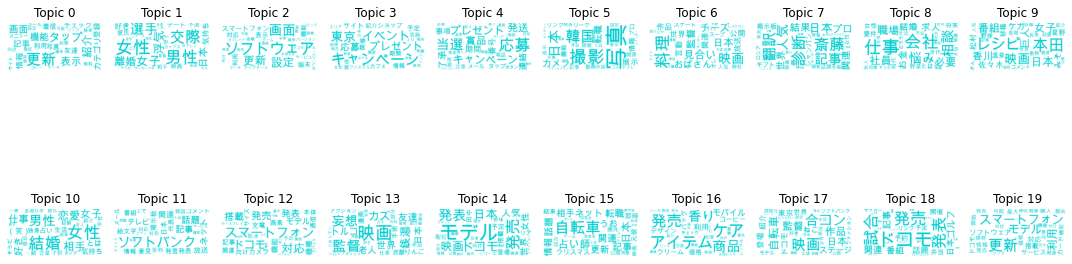

In [22]:
def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

# Visualize
ncols = math.ceil(num_topics/2)
nrows = math.ceil(lda_model.num_topics/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,7))
axs = axs.flatten()



for i, t in enumerate(range(lda_model.num_topics)):
    
    x = dict(lda_model.show_topic(t, 30))
    im = WordCloud(
        font_path=FONT,
        background_color='white',
        color_func=color_func,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))

plt.tight_layout()
plt.savefig("./visualize_news_topics.png")

The above cleanly shows the topics that are discussed among the 7000 news articles.

### Visualizing using pyLDAvis

In [23]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.103455 -0.010451       1        1   4.289558
1     -0.160793  0.019050       2        1   4.524302
2      0.264849  0.039014       3        1   7.633134
3      0.011488 -0.071047       4        1   5.479529
4      0.062965 -0.149665       5        1   2.092201
5      0.039756  0.050525       6        1   3.325767
6     -0.104054 -0.089242       7        1   3.722375
7     -0.037631  0.005936       8        1   1.602366
8     -0.089935  0.159209       9        1   5.636283
9     -0.115234 -0.050565      10        1   2.111055
10    -0.178919  0.102351      11        1  10.273156
11    -0.030974  0.041650      12        1   8.410670
12     0.207204  0.033371      13        1   9.298147
13    -0.075570 -0.062622      14        1   2.151374
14    -0.027616 -0.018042      15        1   5.557661
15    -0.056461  0.027283      16        1   3.272935
16     0.080942  0.003484      17        1   4.371509
17    -0.079157 -0.054973      18        1   5.256209
18    -0.005649 -0.005605      19        1   4.908594
19     0.191333  0.030337      20        1   6.083174, topic_info=         Term         Freq        Total Category  logprob  loglift
746        更新  4807.000000  4807.000000  Default  30.0000  30.0000
10832  ソフトウェア  3138.000000  3138.000000  Default  29.0000  29.0000
373        結婚  3767.000000  3767.000000  Default  28.0000  28.0000
421        写真  3311.000000  3311.000000  Default  27.0000  27.0000
10693  ソフトバンク  3242.000000  3242.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
368        発表   382.042643  4131.625454  Topic20  -5.1242   0.4187
3487       向け   310.212812  2823.105800  Topic20  -5.3325   0.5913
103        関連   328.389793  4389.979746  Topic20  -5.2755   0.2068
85         記事   304.049495  4614.846969  Topic20  -5.3525   0.0798
412       リンク   285.173279  2473.574027  Topic20  -5.4166   0.6393

[1552 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
2594      20  0.847592  あいさつ
10089      1  0.065020   あいつ
10089      7  0.032510   あいつ
10089     10  0.877773   あいつ
4686       6  0.025645    あき
...      ...       ...   ...
246       16  0.013806   （笑）
246       17  0.011176   （笑）
246       18  0.044704   （笑）
246       19  0.046677   （笑）
246       20  0.017093   （笑）

[9387 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [24]:
pyLDAvis.save_html(vis, 'pyldavis_output_news.html')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 5. Optimization of model

### Computing Model Perplexity and Coherence

The perplexity and coherence measures of a topic model conveniently allows evaluating how good the model is, depending on the number of topics we allow it to derive. 

In [29]:
# printing perplexity and coherence
print("Perplexity: ", lda_model.log_perplexity(corpus))

coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity:  -8.937337950435028
Coherence Score:  0.47268476749566446


### Building an LDA Mallet Model

In [33]:
# Found through http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = './mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=dictionary)

# TODO later

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# topics
# ldamallet.show_topics(formatted=False)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Optimization

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 9/9 [03:32<00:00, 23.59s/it]
findfont: Font family ['TakaoGothic'] not found. Falling back to DejaVu Sans.


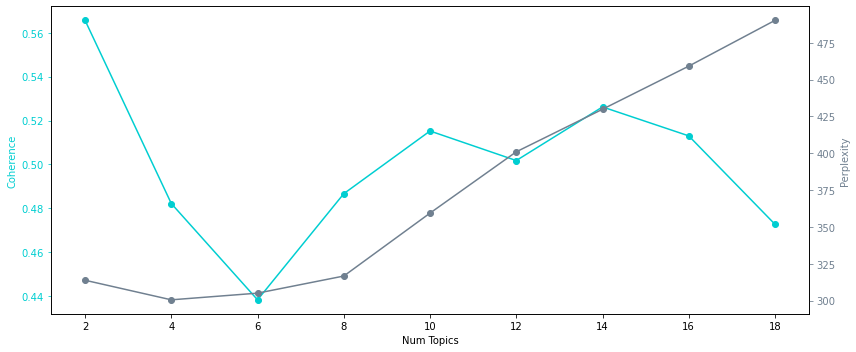

In [25]:
from tqdm import tqdm
import matplotlib
import matplotlib.pylab as plt
font = {'family': 'TakaoGothic'}
matplotlib.rc('font', **font)

start = 2
limit = 20
step = 2

coherence_vals = []
perplexity_vals = []
for n_topic in tqdm(range(start, limit, step)):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topic, random_state=0)
    perplexity_vals.append(np.exp2(-lda_model.log_perplexity(corpus)))
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_vals.append(coherence_model_lda.get_coherence())

x = range(start, limit, step)

fig, ax1 = plt.subplots(figsize=(12,5))

c1 = 'darkturquoise'
ax1.plot(x, coherence_vals, 'o-', color=c1)
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence', color=c1); ax1.tick_params('y', colors=c1)

c2 = 'slategray'
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color=c2)
ax2.set_ylabel('Perplexity', color=c2); ax2.tick_params('y', colors=c2)

ax1.set_xticks(x)
fig.tight_layout()
plt.show()

In [37]:
num_topics = 4
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=0)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


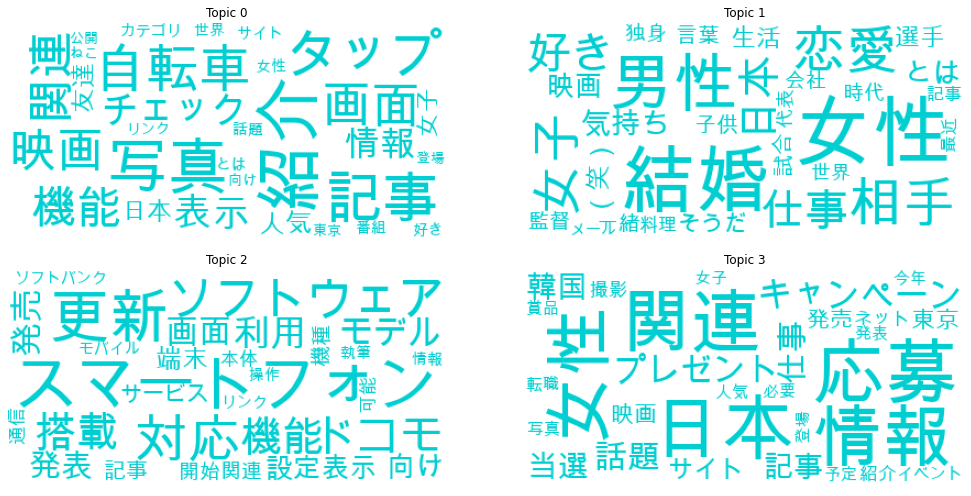

In [38]:
def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

# Visualize
ncols = math.ceil(num_topics/2)
nrows = math.ceil(lda_model.num_topics/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,7))
axs = axs.flatten()



for i, t in enumerate(range(lda_model.num_topics)):
    
    x = dict(lda_model.show_topic(t, 30))
    im = WordCloud(
        font_path=FONT,
        background_color='white',
        color_func=color_func,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))

plt.tight_layout()
plt.savefig("./visualize_news_topics.png")

In [39]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
vis

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.018191  0.067410       1        1  16.939754
1      0.144835 -0.015892       2        1  28.425311
2     -0.192011 -0.011624       3        1  27.382680
3      0.028986 -0.039893       4        1  27.252255, topic_info=          Term         Freq        Total Category  logprob  loglift
746         更新  4431.000000  4431.000000  Default  30.0000  30.0000
5367   スマートフォン  4675.000000  4675.000000  Default  29.0000  29.0000
10832   ソフトウェア  3190.000000  3190.000000  Default  28.0000  28.0000
373         結婚  4397.000000  4397.000000  Default  27.0000  27.0000
2366        対応  4081.000000  4081.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
936         予定   617.323955  2179.680247   Topic4  -6.1439   0.0385
1096        会社   571.652727  1669.334295   Topic4  -6.2208   0.2284
641         必要   594.234484  2326.881336   Topic4  -6.1821  -0.0650
368         発表   600.217903  3389.242525   Topic4  -6.1720  -0.4310
1506        女子   572.655097  3037.098005   Topic4  -6.2191  -0.3683

[370 rows x 6 columns], token_table=       Topic      Freq Term
term                       
6388       1  0.011281  おでん
6388       2  0.011281  おでん
6388       3  0.011281  おでん
6388       4  0.958845  おでん
562        1  0.039254  お互い
...      ...       ...  ...
16258      4  0.034615   麻里
246        1  0.115427  （笑）
246        2  0.607085  （笑）
246        3  0.106692  （笑）
246        4  0.170957  （笑）

[1026 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])